# BASIN-HOPPING ALGORITHM [PRJCT]
A Global Optimization Method

due date: December 5, 2018.

----------------------------------------------------------------------------------------------------------------------

"Basin-hopping is a two-phase method that combines a global stepping algorithm with local minimization at each step. Designed to mimic the natural process of energy minimization of clusters of atoms, it works well for similar problems with 'funnel-like, but rugged' energy landscapes"

The algorithm is iterative with each cycle composed of the following features:

1. random disturbance of the coordinates
2. local minimization
3. accept or reject the new coordinates based on the minimized function value

-https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.basinhopping.html


----------------------------------------------------------------------------------------------------------------------

In this project, we were asked to choose 3 numbers from between N=10-20 to compute the global minimum of each using the basin-hopping algorithm contained in the scipy library. I decided to choose N=12, 17, and 20.

The cell below is important as it contains the functions that work hand in hand to simulate random initial positions of these atoms to then compute the global minimum. More specifically, the Lennard-Jones Potential (LJP) function will do the ground state energy calculations and the "total_energy" function will generate the distances (r) between the atoms to be then inputted into the LJP equation to sum up the system's overall potential energy. What we calculate in the end relates to the notion of the configuration of atoms depending on the energy level of the system. With this type of mathematical optimization, we can map the energy landscape of these atoms.

Using ASE (Atomic Simulated Environment), we can predict and visualize these shapes geometrically typically as icosahedrons when the atoms are in their relaxed state.

----------------------------------------------------------------------------------------------------------------------

In [22]:
from scipy.optimize import minimize
import numpy as np
from numba import jit
import matplotlib.pyplot as plt

epsilon = 1
delta = 1

@jit
def LJP(r):
    A = 4*epsilon*delta**12
    B = 4*epsilon*delta**6
    r6 = r**6
    r12 = r6*r6
    return (A/r12) - (B/r6)

@jit
def total_energy(positions):

    E = 0
    N_atom = int(len(positions)/3)

    for i in range(N_atom-1):
    
        for j in range(i+1, N_atom):
            
            pos1 = positions[i*3 : (i+1)*3]
            pos2 = positions[j*3 : (j+1)*3]
            dist = np.linalg.norm(pos1 - pos2)
            
            # calculate LJP
            E += LJP(dist)
            
    return E

@jit
def init_pos(N, scalar = 5):
    """
    spit out array of  N*3 coordinates 3 dimensions for each atom.
    """
    return scalar * np.random.random_sample((N*3,))

## Calculating ground state potential using scipy.minimize: Conjugate Gradient

In [ ]:
# CHANGE PARAMETERS HERE

x = []
f = []
N_steps = 10
N_atoms = 17    # 20, 12

#-----#-----#-----#-----#-----#-----#-----#-----#-----#-----#-----#

# Conjugent gradient method from scipy to calculate ground state potential energy
@jit
def ground_state_potential(N_steps):
    
    for i in range(N_steps+1):
        pos = init_pos(N_atoms)
        res = minimize(total_energy, pos, method='CG', tol=1e-4)
        f.append(res.fun)
        x.append(res.x)
        
        if i%5==0:
            print('step: ', i, '  values:', res.fun)
    #print(f)
    
    return min(f)

In [6]:
print("Finding global min in "+str(N_steps)+" steps...")
print("...the ground state between "+str(N_atoms)+" atoms using scipy.optimize.minimize: "
      , ground_state_potential(N_steps))

Finding global min in 30 steps...
step:  0   values: -71.57207348617933
step:  5   values: -37.967600518555955
step:  10   values: -72.4582858593149
step:  15   values: -62.204109180333646
step:  20   values: -35.224667863553954
step:  25   values: -70.27660781321731
step:  30   values: -64.42216409812508
...the ground state between 20 atoms using scipy.optimize.minimize:  -75.2812141515449


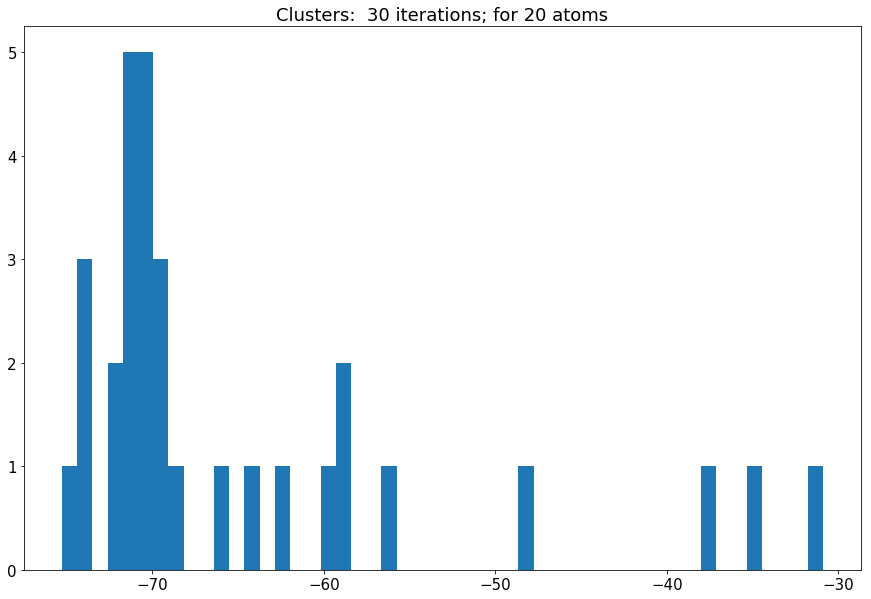

In [16]:
plt.title('Clusters:  '+str(N_steps)+' iterations; for '+str(N_atoms)+' atoms')
plt.hist(f,50)
plt.show()

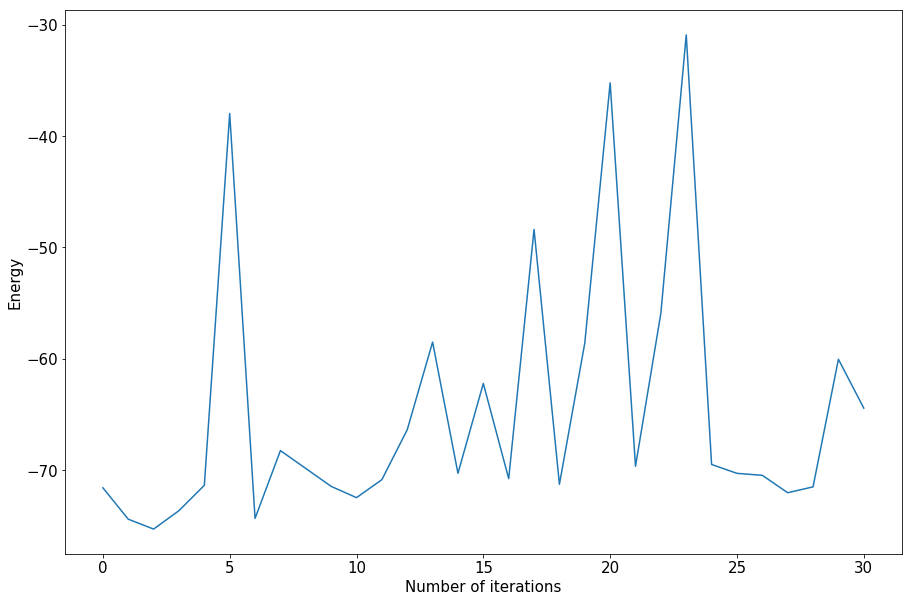

In [15]:
# PLOT the function here
plt.plot(f)
plt.xlabel('Number of iterations')
plt.ylabel('Energy')
plt.show()

### The above graph seems to noisy and it shows us both local minima and maxima. We need to avoid the maxima to only just give us the minima and pick the global minimum. To do this, we use simulated annealing.

## Simulated Annealing

A type of global optimization mimicking the natural phenomenon that occurs in atoms when heating and slow-cooling solid metals, simulated annealing can be applied to the problem of removing the maxima from energy landscape we are trying to see, which is mainly the minima.

The first two functions is essential for simulated annealing to serve as some sort of criteria for accepting a new minimum at each step. The 'neighbor' function will produce a neighboring point near the current minimum to compare to, while the 'acceptance_probability' function acts as the criteria for accepting new minimum depending on the temperature(kT) and the change in potential energy(dE). We utilize the minimization package in the simulated annealing algorithm to perform local minimizations, still by CG method, in each cycle.

In [9]:
@jit
def neighbor(pos_now, kT):
    N = len(pos_now)
    return pos_now + kT*np.random.random_sample((N,))

@jit
def acceptance_probability(dE, kT):
    if dE<0:
        return 1
    else:
        return np.exp(-dE/kT)

@jit
def simulated_annealling_v3(N_atom, Max_iteration, kT):
    energy_hist = []
    pos_now = init_pos(N_atom)
    res = minimize(total_energy, pos_now, method='CG', tol=1e-3)
    obj_now = res.fun

    for i in range(Max_iteration):
        pos_new = neighbor(pos_now, kT)
        res = minimize(total_energy, pos_new, method='CG', tol=1e-3)        
        obj_new = res.fun
        ap = acceptance_probability(obj_new-obj_now, kT)
        if ap > np.random.random():
            print('accept new energy: ', obj_new, ' acceptance ratio: ', ap)
            obj_now = obj_new
            pos_now = pos_new
        energy_hist.append(obj_now)
    return pos_now, obj_now, energy_hist


In [10]:
pos_min, eng_min, eng_hist = simulated_annealling_v3(N_atom=N_atoms, Max_iteration=N_steps, kT=1.0)

accept new energy:  -74.3679051623534  acceptance ratio:  1.0
accept new energy:  -77.17704256108007  acceptance ratio:  1.0


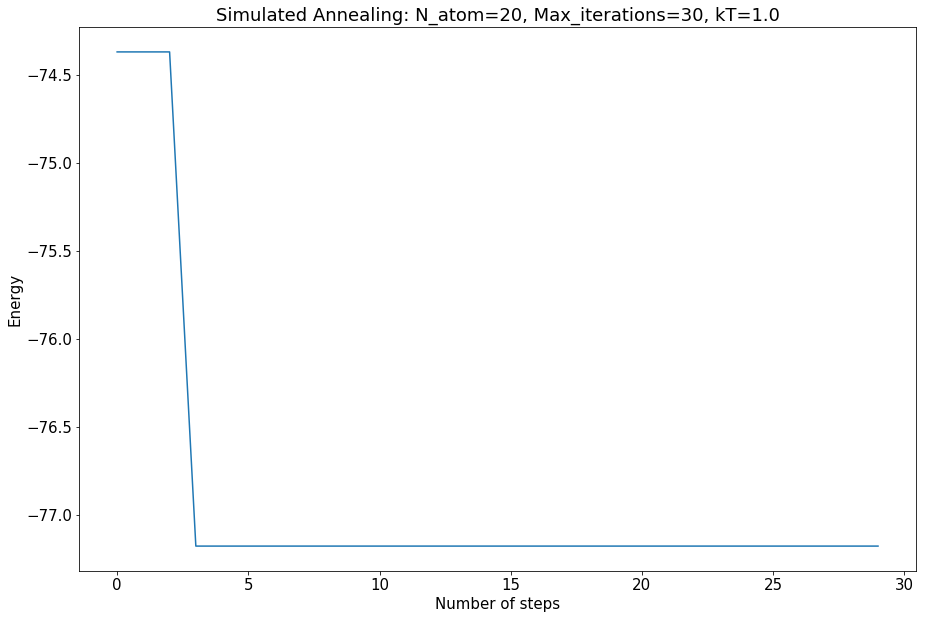

In [14]:
plt.plot(eng_hist)
plt.title('Simulated Annealing: N_atom='+str(N_atoms)+', Max_iterations='+str(N_steps)+', kT=1.0')
plt.xlabel('Number of steps')
plt.ylabel('Energy')
plt.show()

### The challenge here now is that annealing tends to get stuck at some local minima. But at some cases I do get the global minima right (that also gets stuck) so the find is really not that convincing when you see it on the above graph. How can we solve this?

## Basin-Hopping Algorithm

One of its features is a random disturbance or perturbation on the coordinates. With this, we can avoid remaining at some minima and then continue on with the local minimization at each step using the basin-hopping algorithm.

In [45]:
from scipy.optimize import basinhopping
# CHANGE PARAMETERS HERE

T = 3.0
stepsize = 4.0
# minimizer_kwargs = {"method": "CG"}

#-----#-----#-----#-----#-----#-----#-----#-----#-----#-----#-----#-----#-----#-----#

# define a function that stores values at each step
Minimum_E = []

@jit 
def store_values(pos, total_energy, accepted):
    print("Minimum at %.4f accepted %d" % (total_energy, int(accepted)))
    print(pos)
    Minimum_E.append(total_energy)

#-----#-----#-----#-----#-----#-----#-----#-----#-----#-----#-----#-----#-----#-----#


# performs basin-hopping algorithm in N_steps to find the smallest of all minimums.
# I added the callback function within the BH algorithm so it can store the total_energy for each step
@jit
def BHOP(N_atoms):
    pos = init_pos(N_atoms)
    res = basinhopping(total_energy, pos, niter=15, T=T, stepsize=stepsize, disp=False
                   , callback=store_values) #, minimizer_kwargs=minimizer_kwargs)
    
    print("")
    print("The ground state value via basin-hopping algorithm between "+str(N_atoms)+" atoms is:", res.fun)

In [46]:
BHOP(N_atoms)

Minimum at -59.3694 accepted 1
[2.45979523 2.51750675 4.56731391 2.7436988  2.84974644 3.57575305
 3.63486035 3.44961841 3.48217464 1.83958479 2.26087346 3.65159461
 3.39808471 2.28094369 2.0584079  2.95724939 3.52856479 4.38898107
 4.07551278 3.5019938  4.49299713 3.53307429 2.56719028 4.24938125
 2.86737269 1.79329798 3.78231877 2.61259606 3.90457894 3.36887687
 1.93480327 3.11491164 2.90935819 3.60849572 2.37060632 3.14419502
 2.5441235  2.16550283 2.76499172 4.49204389 2.50960393 4.80002674
 4.48129495 2.78014999 3.7144052  1.8902224  3.33478204 4.02808001
 3.01814158 3.18423332 2.58511575]
Minimum at -56.7248 accepted 0
[1.33320382 3.07780127 5.63755727 2.00528156 2.21648706 2.97753815
 2.17534602 3.75327226 3.74761676 1.44541481 1.70462876 4.38361939
 0.92845499 2.65680198 4.63637876 2.76974123 2.88298756 3.38654465
 2.4367826  3.28041344 5.50234086 2.4854692  1.98119702 4.03237735
 1.81710384 1.2563006  3.46147438 1.74562203 2.7440521  3.90310633
 1.00056187 2.07505868 3.4574063

Minimum at -54.5594 accepted 1
[ 2.39517518 -1.34961205  3.82818667  4.29537321 -2.52987668  3.53332781
  3.88643112  0.17414269  4.69472362  3.47441849 -3.09923857  4.01797022
  3.44254055 -2.86010379  2.90729712  3.31905919 -0.58498509  5.25050694
  4.94202164 -1.76323667  3.03505958  4.26303325 -0.89472776  4.73638084
  4.19347195 -1.46838621  3.79096857  3.30397949 -1.02107042  3.32651723
  4.07496946 -0.37972429  3.76495815  3.94585749 -2.2230879   4.55055489
  3.30851241 -1.33588938  4.44563533  3.02749903 -0.33217827  4.16624752
  2.34709785 -0.91593873  4.84256638  3.25183268 -2.07945457  3.66425011
  3.85852337 -1.8198124   2.78096109]
Minimum at -52.8004 accepted 1
[  4.98377802  -1.79094883   2.62326161   3.33944625  -1.64576365
   4.24014043   4.03347539  -0.77814994   3.9540514   -7.48778263
 -16.69185435  -9.06291536   4.35586087  -3.32363401   4.18696879
   3.97883539  -2.36855835   3.75493765   4.3351182   -1.53692902
   4.69487945   4.05465678  -2.37400597   2.6468121 

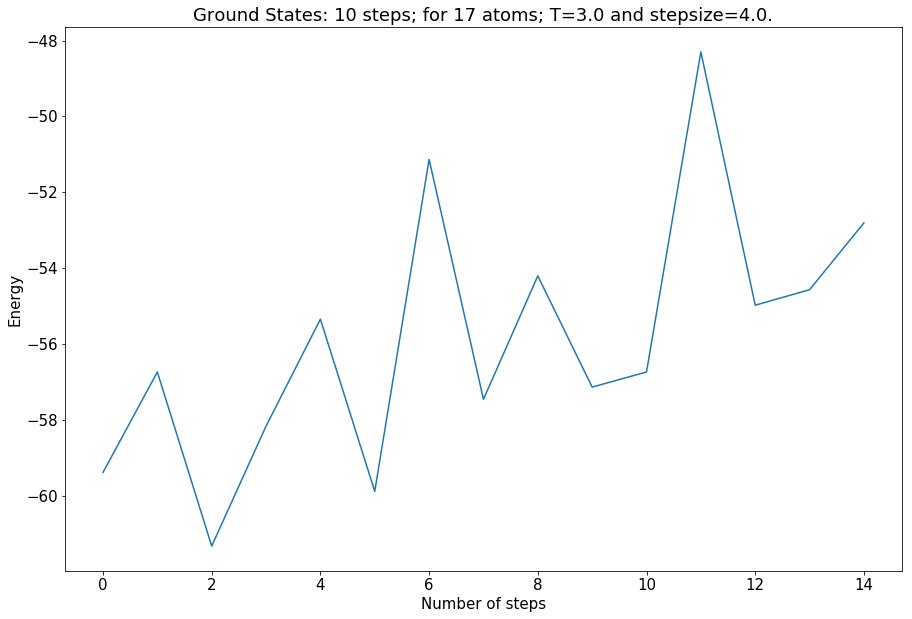

In [66]:
# PLOT THE BHOP algorithm as a function of steps
print('')
plt.plot(Minimum_E)
plt.title('Ground States: '+str(N_steps)+' steps; for '+str(N_atoms)+' atoms; T='+str(T)+' and stepsize='+str(stepsize)+'.')
plt.xlabel('Number of steps')
plt.ylabel('Energy')
plt.show()
print('')

## N = 12

The resulting global minimum for 12 atoms is -37.9676. Verifying from this website: http://doye.chem.ox.ac.uk/jon/structures/LJ/tables.150.html, this result suffices.
Changing the parameter(s) around, with high temperature -- at T=100.0 and stepsize=3.0 -- it produced a seemingly odd shape iterating it 60 times. See figA.

While the temperature was raised, it allowed the algorithm to find the ground state at only 10 steps, but as it continues, it exits and deviates away from the true ground state. This resembles a "hop" from a "basin" of local minima. With a high temperature the algorithm will accept even the biggest of jumps with the values. This occurrence is depicted at around steps 30 and 40 in the figure above.

Running the algorithm again to see if it behaves differently, in figB, it searched for the minimum very early but it did not actually find the proper ground state according to the given link. Although, it continued to accept huge jumps with the recorded values as it is still under high temperature. With more tries under high T, there seems to be several instances where I do not correctly find the global minimum but it maintains the basin shape. So it is safe to say that there are some inaccuracies with the algorithm when the temperature is up to 100. 

At low temperatures, tuning it down to T=10.0 and stepsize=3.0 (see figC), the inaccuracies still ensues but it finds the minimum in under 40 steps and it is still accepting drastic climbs but losing its frequence. Taking a closer look during other trials in T=10.0, the global minimum can be found twice or more times in one run, and the probability of estimating the proper minimum is much better set on these parameters settings. Also the spread of the data is becoming more localized to fewer "basins" accepting fewer jumps in value. Furthermore, dropping the temperature to T=2.0, the search for the global minimum resulted in some consistence around the general area where the true minimum is at.
 

In [57]:
# Visulize Atoms using ASE (Atomic Simulation Environment)
# To install: "conda install -c conda-forge ase"

from ase import Atoms

# these coordinates are copy-pasted from http://doye.chem.ox.ac.uk/jon/structures/LJ/tables.150.html

N12_pos = [0.2554245657,       -0.7597155830,        0.8059835272,
          0.5283253377,        0.9897998883,        0.1821754467,
         -0.5997802033,        0.8673465165,        0.4242568675,
          1.0568739378,       -0.0157847459,        0.4180799298,
         -0.7684429943,       -0.2139178301,        0.8097866524,
         -0.2229503268,        0.7895914511,       -0.6395424769,
          0.6115264731,       -0.7980514036,       -0.2670688620,
         -0.4892364945,       -0.9175362229,       -0.0308514186,
          0.7761020388,        0.2570139805,       -0.6432655993,
         -1.0049747907,        0.0636802183,       -0.2610548345,
         -0.1634049827,       -0.3001501148,       -0.9132836927,
          0.0205374392,        0.0377238456,        0.1147844603]


i = 0
N12 = []

while i<len(N12_pos):
    N12.append(N12_pos[i:i+3])
    i+=3
    
N12

[[0.2554245657, -0.759715583, 0.8059835272],
 [0.5283253377, 0.9897998883, 0.1821754467],
 [-0.5997802033, 0.8673465165, 0.4242568675],
 [1.0568739378, -0.0157847459, 0.4180799298],
 [-0.7684429943, -0.2139178301, 0.8097866524],
 [-0.2229503268, 0.7895914511, -0.6395424769],
 [0.6115264731, -0.7980514036, -0.267068862],
 [-0.4892364945, -0.9175362229, -0.0308514186],
 [0.7761020388, 0.2570139805, -0.6432655993],
 [-1.0049747907, 0.0636802183, -0.2610548345],
 [-0.1634049827, -0.3001501148, -0.9132836927],
 [0.0205374392, 0.0377238456, 0.1147844603]]

In [58]:
N12_configuration = Atoms('N12',
             positions=N12)

In [59]:
from ase.visualize import view

In [60]:
view(N12_configuration, viewer='x3d')

## N = 17

For 17 atoms, the recorded ground state is -61.317995 from the website above. Running the basin-hopping program in jupyter, the best resulting ground state it could produce was -61.307146. Using the parameters T=100.0 and stepsize=3.0, the program provided a plot with the same basin shape (as figA) but not achieving the proper minimum. After many attempts and trying different parameters, still the algorithm could not seem to hit the correct global minimum.

Some days after of last running the program, I tried the parameters T=2.0 and stepsize=7.0 (increasing the stepsize by a few notches), the target minimum was finally found; to be exact, it is -61.31799466010683. And then actually found it again on the next run, producing 61.31799466009076 as the global minimum. After a few more runs, it seems that these parameters are consistent in producing the global minimum. In the 3rd run, the algorithm found the global minimum in under 15 steps which is a huge improvement from the previous runs.

In [61]:
N17_pos = [-1.4927890568,        0.0801950784,       -0.4804022863,
          0.3832871935,       -0.2308985319,        1.5051295549,
         -1.2645827158,        0.2836524175,        0.6214942924,
         -0.6590981862,       -0.5449554650,        1.1552042113,
          0.6253588579,       -0.2290468923,       -1.1845756108,
          1.1789008612,        0.4741304013,       -0.4818155915,
          0.1986774699,        0.7973208850,       -0.9760036492,
          1.0927216037,       -0.6219066728,       -0.2167268299,
          0.0748361582,       -0.9869157414,       -0.5577188980,
          0.4123558404,        1.0530918138,        0.1077499046,
         -0.5000444130,       -0.1017982275,       -0.9994331852,
          0.9373386533,        0.1611949221,        0.5955520332,
         -0.6216625830,        0.6970177369,       -0.2047505596,
          0.2605803622,       -0.7460656159,        0.5382462185,
         -0.6917603796,       -0.4522573646,        0.0518014568,
         -0.1642913474,        0.3359763080,        0.7388374053,
          0.2301716815,        0.0312649485,       -0.2125884666]


i = 0
N17 = []

while i<len(N17_pos):
    N17.append(N17_pos[i:i+3])
    i+=3
    
N17

[[-1.4927890568, 0.0801950784, -0.4804022863],
 [0.3832871935, -0.2308985319, 1.5051295549],
 [-1.2645827158, 0.2836524175, 0.6214942924],
 [-0.6590981862, -0.544955465, 1.1552042113],
 [0.6253588579, -0.2290468923, -1.1845756108],
 [1.1789008612, 0.4741304013, -0.4818155915],
 [0.1986774699, 0.797320885, -0.9760036492],
 [1.0927216037, -0.6219066728, -0.2167268299],
 [0.0748361582, -0.9869157414, -0.557718898],
 [0.4123558404, 1.0530918138, 0.1077499046],
 [-0.500044413, -0.1017982275, -0.9994331852],
 [0.9373386533, 0.1611949221, 0.5955520332],
 [-0.621662583, 0.6970177369, -0.2047505596],
 [0.2605803622, -0.7460656159, 0.5382462185],
 [-0.6917603796, -0.4522573646, 0.0518014568],
 [-0.1642913474, 0.335976308, 0.7388374053],
 [0.2301716815, 0.0312649485, -0.2125884666]]

In [62]:
N17_configuration = Atoms('N17',
             positions=N17)

In [63]:
view(N17_configuration, viewer='x3d')

## N = 20

I wanted try and find the ground state of 20 atoms and see if I could find the right parameters to calculate the global minimum. I assumed that having more atoms it is harder to find the optimal values to help search for the global minimum. After entering many different combinations of parameters, using T=2.75 and stepsize=9.0 in under 30 iterations, the algorithm successfully discovered the indicated minimum that satisfies the value in the webpage above (-77.177043). From running the algorithm in Jupyter, this best solution found for the global minimum, as it "hops" down to, is -77.17704256829511.

In [54]:
N20_pos = [1.0542134354,       -0.8081155374,       -0.8780673234,
          0.5720956451,       -0.5998126076,        1.3522140648,
         -0.6547694631,        0.6632374824,       -1.2833228946,
         -0.5638250461,       -0.3831626191,        1.2527616580,
         -1.3194651984,        0.3947624749,       -0.3705203274,
         -0.5877294589,        1.2658717257,       -0.2936651341,
          0.1678939750,        0.4879537712,        1.3295986940,
         -0.0740393394,       -1.2044588525,        0.6265543196,
          1.1137376937,        0.2095946060,        0.7512751931,
         -0.8267072928,       -0.4295977333,       -0.9903350896,
          0.3610938518,        0.9844358195,       -0.8655803464,
          0.9609389794,       -0.8311438126,        0.2715643524,
          0.2417893267,       -0.0907880210,       -1.2732853490,
         -0.6975137814,        0.5346545196,        0.5809193969,
         -0.8531438989,       -0.5007623337,        0.1571668221,
          0.3269372428,        0.9041032794,        0.2810889593,
          0.0643113741,       -0.7953329875,       -0.4110834173,
          0.8267294552,        0.1122963271,       -0.3310266457,
         -0.2564446761,        0.2492129341,       -0.3831410162,
          0.1438971757,      -0.1629484353,        0.4768840837]


i = 0
N20 = []

while i<len(N20_pos):
    N20.append(N20_pos[i:i+3])
    i+=3
    
N20

[[1.0542134354, -0.8081155374, -0.8780673234],
 [0.5720956451, -0.5998126076, 1.3522140648],
 [-0.6547694631, 0.6632374824, -1.2833228946],
 [-0.5638250461, -0.3831626191, 1.252761658],
 [-1.3194651984, 0.3947624749, -0.3705203274],
 [-0.5877294589, 1.2658717257, -0.2936651341],
 [0.167893975, 0.4879537712, 1.329598694],
 [-0.0740393394, -1.2044588525, 0.6265543196],
 [1.1137376937, 0.209594606, 0.7512751931],
 [-0.8267072928, -0.4295977333, -0.9903350896],
 [0.3610938518, 0.9844358195, -0.8655803464],
 [0.9609389794, -0.8311438126, 0.2715643524],
 [0.2417893267, -0.090788021, -1.273285349],
 [-0.6975137814, 0.5346545196, 0.5809193969],
 [-0.8531438989, -0.5007623337, 0.1571668221],
 [0.3269372428, 0.9041032794, 0.2810889593],
 [0.0643113741, -0.7953329875, -0.4110834173],
 [0.8267294552, 0.1122963271, -0.3310266457],
 [-0.2564446761, 0.2492129341, -0.3831410162],
 [0.1438971757, -0.1629484353, 0.4768840837]]

In [55]:
N20_configuration = Atoms('N20',
             positions=N20)

In [56]:
view(N20_configuration, viewer='x3d')

## Conclusion

The basin-hopping algorithm performs more efficiently in handling multi-iterated and multivariable global optimization computing than just the ordinary minimization under the conjugate gradient descent method from the scipy kit. The ordinary minimize scipy function merely gives us an idea about the clusters of local minimas but fails to show us the true global minimum with higher number of atoms. In comparison to the other, simulated annealing allows for a search of global minimum also but it tends to get stuck at a some local minimum at some point. This is a problem that can be solved by the basin-hopping algortihm.

Running the basin-hopping algorithm on my laptop, it seems to be that the higher number of atoms, the more difficult it is for the computer to process as it needs more computing power to calculate the global minimum due to more iterations that need to happen from simply having more atoms. When trying to calculating N=10, 11, or 12, using the regular minimization package was sufficient to correctly guess the global minimum as well. But as I raised the number of atoms, these regular tools started to fail or become more innacurate.

When considering a higher amount of atoms, the basin-hopping algorithm can be relied on due of its inherent parameters that we can freely adjust. What I found is that, in general, slightly raising the temperature and stepsize help it find global minimum when the number of atoms increases. So by simply changing some parameters we attain our target.

Are these found parameters the most optimal ones to lead us the global minimum especially when increasing the atom count?

-Still not quite sure since my computer takes a few minutes to calculate.

-Thanks to @jit the functions ran a lot faster.

In [65]:
# resize figure and font
plt.rcParams['figure.figsize'] = (15,10)
plt.rcParams.update({'font.size': 15})